# 深度卷积生成对抗网络DCGAN

在上一次的学习中，我们搭建了一个朴素GAN，只利用了全连接网络，在训练了20000epoch后已经可以生成比较不错的手写数据集了，如果把生成器和判别器网络换成更强大的网络会是不是会有更好的效果呢？DCGAN引入了卷积神经网络，使用卷积神经网络进行生成器和判别器的构造，结构与朴素GAN基本相同，所以不过多介绍了，下面是搭建过程。

In [1]:
# 导入包
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# 模型输入维度
img_rows = 28
img_cols = 28
channels = 1
# 图像大小
img_shape = (img_rows, img_cols, channels)
# 噪声向量大小
z_dim = 100

## 构造生成器

DCCAN中的生成器和判别器引入了ConvNet，图像以高度X宽度X彩色通道数作为输入，并通过一系列卷积层输出一个维数为1 X n的类别得分向量，n是类别标签数。要使用ConvNet结构生成图像，则是上述过程的逆过程：并非获取图像再将其处理为向量，而是获取向量并调整其大小以使之变为图像。
在生成器中，我们通过`转置卷积`，增加高度和宽度，同时减少深度，最后生成一个图像。
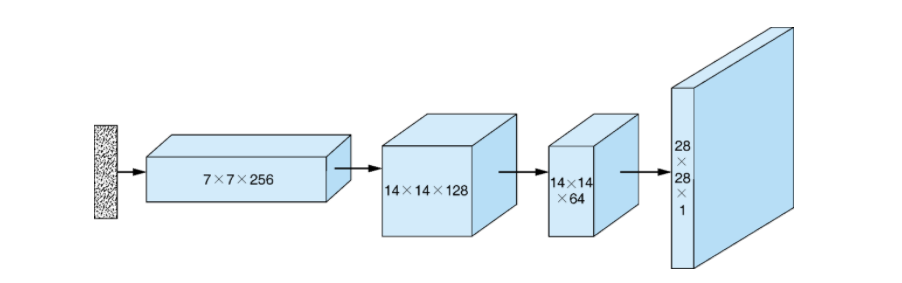

构造的综合步骤：

（1）取一个随机噪声向量Z，通过全连接层将其重塑为7×7×256张量。

（2）使用转置卷积，将7×7×256张量转换为14×14×128张量。

（3）应用批归一化和LeakyReLU激活函数。

（4）使用转置卷积，将14×14×128张量转换为14×14×64张量。注意：宽度和高度尺寸保持不变。可以通过将Conv2DTranspose中的stride参数设置为1来实现。

（5）应用批归一化和LeakyReLU激活函数。

（6）使用转置卷积，将14×14×64张量转换为输出图像大小28×28×1。

（7）应用tanh激活函数。

In [3]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    return model

## 构造判别器

判别器将生成器的的步骤反过来，
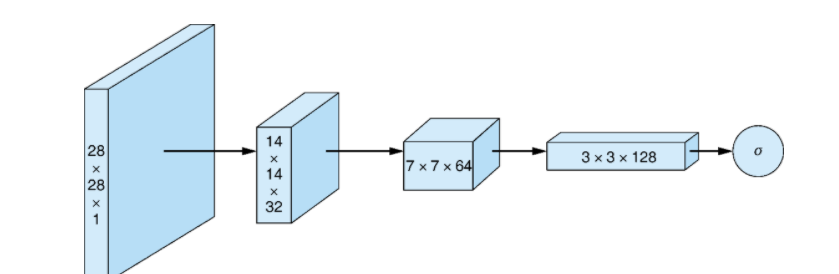

搭建步骤如下：

（1）使用卷积层将28×28×1的输入图像转换为14×14×32的张量。

（2）应用LeakyReLU激活函数。

（3）使用卷积层将14×14×32的张量转换为7×7×64的张量。

（4）应用批归一化和LeakyReLU激活函数。

（5）使用卷积层将7×7×64的张量转换为3×3×128的张量。

（6）应用批归一化和LeakyReLU激活函数。

（7）将3×3×128张量展成大小为3×3×128=1152的向量。

（8）使用全连接层，输入sigmoid激活函数计算输入图像是否真实的概率。

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

## 搭建DCCGAN

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
generator = build_generator(z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Instructions for updating:
Colocations handled automatically by placer.


## 训练

In [9]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    mnist=tf.keras.datasets.mnist
    (X_train, _), (_, _) = mnist.load_data(path='./MNIST')
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
#         print(X_train.shape[0])
        imgs = X_train[idx]
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
#         print(imgs.shape)
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z, real)
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            print("%d [D loss: %f, acc.: %.2f%%] [G loss:%f]"%(iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            sample_images(generator)

In [10]:
def sample_images (generator,image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 *gen_imgs +0.5
    fig, axs = plt.subplots(image_grid_rows,image_grid_columns,figsize=(4,4),sharey=True,sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt +=1

1000 [D loss: 0.033553, acc.: 100.00%] [G loss:3.169000]
2000 [D loss: 0.046578, acc.: 100.00%] [G loss:3.762163]
3000 [D loss: 0.093897, acc.: 98.05%] [G loss:3.164207]
4000 [D loss: 0.259975, acc.: 89.06%] [G loss:3.126411]
5000 [D loss: 0.374123, acc.: 80.47%] [G loss:4.488168]
6000 [D loss: 0.064344, acc.: 100.00%] [G loss:4.513868]
7000 [D loss: 0.172723, acc.: 94.53%] [G loss:3.390556]
8000 [D loss: 0.034246, acc.: 99.22%] [G loss:3.154727]
9000 [D loss: 0.014507, acc.: 100.00%] [G loss:3.865969]
10000 [D loss: 0.064371, acc.: 99.61%] [G loss:4.389486]
11000 [D loss: 0.044337, acc.: 99.61%] [G loss:1.461259]
12000 [D loss: 0.044211, acc.: 100.00%] [G loss:3.725124]
13000 [D loss: 0.020543, acc.: 99.61%] [G loss:5.813111]
14000 [D loss: 0.028194, acc.: 99.61%] [G loss:4.433133]
15000 [D loss: 0.007301, acc.: 100.00%] [G loss:4.591091]
16000 [D loss: 0.076855, acc.: 97.66%] [G loss:3.976701]
17000 [D loss: 0.051807, acc.: 99.22%] [G loss:7.181850]
18000 [D loss: 0.049115, acc.: 100

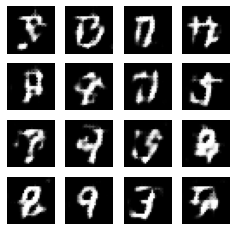

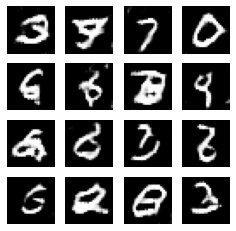

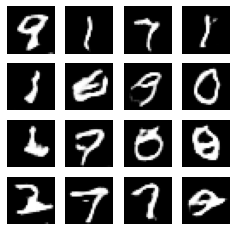

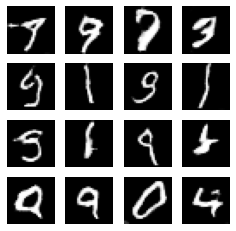

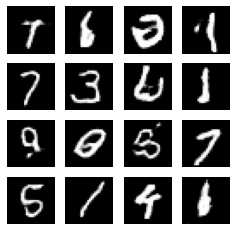

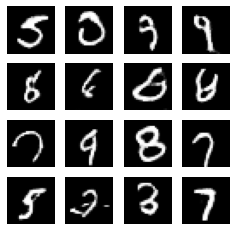

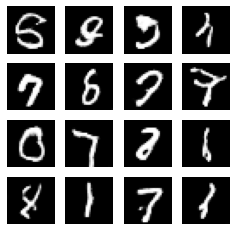

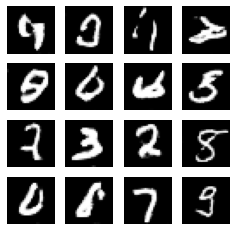

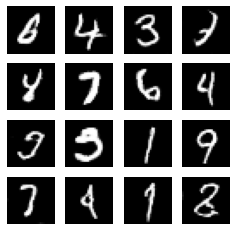

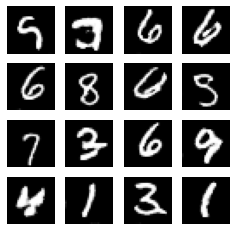

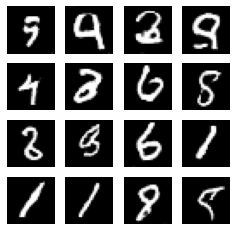

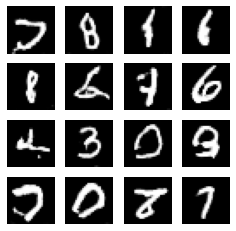

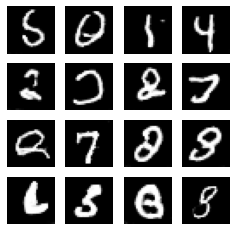

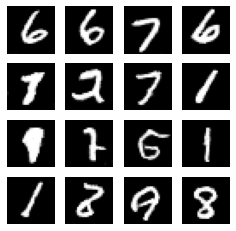

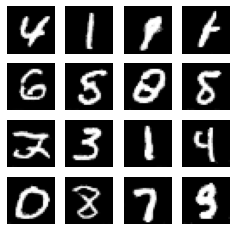

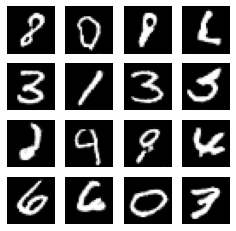

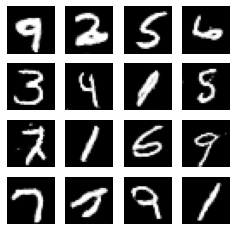

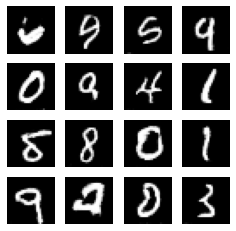

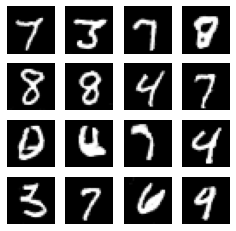

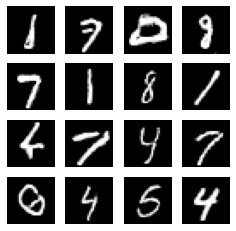

In [11]:
iterations  = 20000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)